In [1]:
#TODO: Legender for BG
#TODO: update README

# LC Extraction for TESS Objects - Complete Runthrough

To use install minimal instance of `astroLuSt` version 1.0.0:
```shell
pip install --no-dependencies git+https://github.com/TheRedElement/astroLuSt
```

Install the missing dependencies as you go (if an error occurs because a package is missing, just install that into your environment)

In [2]:
#%%imports
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroLuSt.database_interface import (
    simbadinterface as aldasi,
    tesscut_interface as aldate
)
from astroLuSt.preprocessing import (
    outlierremoval as alprou,
    photometry as alprph,
    timeseries as alprti
)
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from typing import Tuple


## README

### `objid.csv`
* Contains timeseries data (LC) of the object
* general column-schema: `<parameter>(_<context>)(_e)`
* Columns
    * `flux_corr_globnorm`
        * bg corrected flux normalized by the global median
        * correction done by means of sky-ring background estimate
    * `flux_corr_sectnorm`
        * bg corrected flux normalized sector-wise by the sector median
        * correction done by means of sky-ring background estimate
        * unit: $\frac{e^-}{s}$
    * `flux_raw`
        * raw flux extracted from the cutout
        * extraction by means of aperture photometry
        * unit: $\frac{e^-}{s}$
    * `flux_sr`
        * raw flux of the skyring
        * i.e., background estimate
        * unit: $\frac{e^-}{s}$
    * `mask_pc`
        * mask resulting from percentile-clipping
        * `True` for values to keep, `False` for values to remove  
    * `mask_sc`
        * mask resulting from sigma-clipping
        * `True` for values to keep, `False` for values to remove  
    * `mask_sop`
        * mask resulting from string-of-pearls
        * `True` for values to keep, `False` for values to remove  
    * `period`
        * independent variable converted to period space
        * has range $(0,period)$
        * unit: d
    * `phase`
        * independent variable converted to phase space
        * has range $(0,1)$
        * unit: None
    * `sector`
        * TESS sector the observation was made in
    * `time`
        * extracted timestamp
        unit: $BJD - 2457000$
    * `<parameter>_e`
        * uncertainty associated with `<parameter>`


### `objid_meta.csv`
* Contains metadata to `objid.csv`
* general column-schema: `<parameter>(_<context>)(_e)`
* Columns
    * `cutout_size`
        * size of the cutout used to generate the LC
        * format: `xpixels|ypixels`
    * `dec`
        * declination of the object
        * unit: deg
    * `ids`
        * all other ids listed in [Simbad](http://simbad.u-strasbg.fr/simbad/)
        * separated by `|`
    * `main_id`
        * main id of the object according to [Simbad](http://simbad.u-strasbg.fr/simbad/)
    * `name`
        * object ID
    * `nintervals_sc`
        * number of intervals (bins) used for data-binning within sigma-clipping
    * `npixels_ap`
        * number of pixels the aperture flux got normalized to
    * `npoints_per_interval_sc`
        * number of points each interval (bin) contains for data-binning within sigma-clipping
        * overwrites `nintervals_sc`
            * if `None`, `nintervals_sc` was used
    * `period`
        * period of the objects main variation
        * unit: d
    * `pmax_pc`
        * upper bound of the percentile used in percentile-clipping
    * `pmin_pc`
        * lower bound of the percentile used in percentile-clipping
    * `position_ap`
        * position of the aperture on the cutout 
        * relative to cutout center
        * x- and y-direction separated by `|`
        * unit: pixels
    * `ra`
        * right ascension of the object
        * unit: deg
    * `radius_ap`
        * (outer) radius of the science aperture
        * unit: pixels
    * `radius_inner_ap`
        * inner radius of the science aperture
        * unit: pixels
    * `radius_skyring`
        * (outer) radius of the sky-ring aperture
        * unit: pixels
    * `radius_inner_skyring`
        * inner radius of the sky-ring aperture
        * unit: pixels
    * `sectors`
        * sectors that got extracted for the object
        * separated by `|`
    * `sectors_exclude`
        * sectors that are recommended to excluded from an analysis
        * separated by `|`
    * `sigma_bottom_sc`
        * multiplier for lower bound used in sigma-clipping
    * `sigma_top_sc`
        * multiplier for upper bound used in sigma-clipping
    * `th_sop`
        * threshold for clipping used in string-of-pearls
    * `tref`
        * reference time used for timeseries folding
        * unit: same as `time`
    * `window_size_sop`
        * size of the window used to evaluate threshold condition in string-of-pearls


## Code

In [3]:
def sectornorm(
    X:np.ndarray, X_e:np.ndarray,
    sector:np.ndarray,
    eps:float=1e-9,
    ) -> np.ndarray:
    # ) -> np.ndarray[np.ndarray,np.ndarray]:
    """
        - function to compute a normalized version of X
        - computes
            - normalized X w.r.t. global median (and errors)
            - normalized X w.r.t. sectorwise median (and errors)

        Parameters
        ----------
            - `X`
                - `np.ndarray`
                - 1d
                - series of fluxes to be normalized
            - `X_e`
                - `np.ndarray`
                - same shape as `X`
                - errors corresponding to `X`
            - `sector`
                - `np.ndarray`
                - 1d
                - contains for each frame the sector it was observed in
            - `eps`
                - `float`, optional
                - constant for numerical stability upon division
                - relevant if median of LC is exactly `0.0`
        
        Raises
        ------

        Returns
        -------
            - `X_norm`
                - `np.ndarray`
                - contains normalized versions of `X`
                - 2d
                    - globallly normalized
                    - sector-wise normalized
            - `X_norm_e`
                - `np.ndarray`
                - contains errors corresponding to `X`
                - 2d
                    - globallly normalized
                    - sector-wise normalized

        Dependencies
        ------------
            - `numpy`
        
        Comments
        --------
    """
    #initialize
    X_norm = np.empty((X.shape[0],2))
    X_norm_e = np.zeros_like(X_norm)*np.nan
    
    #compute fluxes and errors
    X_norm[:,0] = X/np.nanmedian(X)
    X_norm_e[:,0] = X_e/np.nanmedian(X)
    for s in np.unique(sector):
        sbool = (sector==s)
        X_norm[sbool,1] = X[sbool] / (np.median(X[sbool]+eps))
        X_norm_e[sbool,1] = X_e[sbool] / (np.median(X[sbool])+eps)
    
    return X_norm, X_norm_e


In [4]:
#%%control
verbose = 3

#saving
lc_dir = f"./"
# lc_dir = False

df_obj = pl.from_dicts([
    # dict(name="TIC 293937699", sectors="2|3", npixels=1, aperture_radius_inner=0, aperture_radius=2, skyring_radius_inner=3.5, skyring_radius=7.5, cutout_size="15|15"),
    dict(
        name="TIC 293937699",
        period=65.108, tref=0.0,
        sectors=None,
        # sectors="2|3|7|8|9|12|13|29|33|36|39",
        # sectors="2|3",
        # sectors="2",
        sectors_exclude="8",
        cutout_size="15|15",
        npixels_ap=1, position_ap="1|1", radius_inner_ap=0, radius_ap=2, radius_inner_skyring=3.0, radius_skyring=7.5,
        window_size_sop=4, th_sop=0.2,
        sigma_bottom_sc=2.0, sigma_top_sc=0.2, nintervals_sc=10, npoints_per_interval_sc=None,
        pmin_pc=6, pmax_pc=78,
    ),
])

print(df_obj)

shape: (1, 20)
┌───────────────┬────────┬──────┬─────────┬───┬───────────────┬────────────────┬─────────┬─────────┐
│ name          ┆ period ┆ tref ┆ sectors ┆ … ┆ nintervals_sc ┆ npoints_per_in ┆ pmin_pc ┆ pmax_pc │
│ ---           ┆ ---    ┆ ---  ┆ ---     ┆   ┆ ---           ┆ terval_sc      ┆ ---     ┆ ---     │
│ str           ┆ f64    ┆ f64  ┆ null    ┆   ┆ i64           ┆ ---            ┆ i64     ┆ i64     │
│               ┆        ┆      ┆         ┆   ┆               ┆ null           ┆         ┆         │
╞═══════════════╪════════╪══════╪═════════╪═══╪═══════════════╪════════════════╪═════════╪═════════╡
│ TIC 293937699 ┆ 65.108 ┆ 0.0  ┆ null    ┆ … ┆ 10            ┆ null           ┆ 6       ┆ 78      │
└───────────────┴────────┴──────┴─────────┴───┴───────────────┴────────────────┴─────────┴─────────┘


In [5]:
#%%get coordinates from Simbad
def get_ids_simbad(
    df_obj_row:pl.DataFrame,
    verbose:int=0
    ) -> pl.DataFrame:
    """
    """
    
    SDI = aldasi.SimbadDatabaseInterface()
    df_ids = pl.from_pandas(SDI.get_ids(
        input_ids=df_obj_row["name"],
    )).rename({"input_id":"name"})

    df_obj_row = df_ids.join(df_obj_row, how="inner", on="name")
    
    if verbose > 2: display(df_obj_row)

    return df_obj_row


In [6]:
#%%download cutout from MAST
def get_tess_cutouts(
    df_obj_row:pl.DataFrame,
    verbose:int=0,
    ) -> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
    """
    """
    cutout_size = df_obj["cutout_size"].str.split("|")[0].to_numpy().astype(int)
    sectors = None if df_obj["sectors"].item() is None else df_obj["sectors"].str.split("|")

    TCI = aldate.TESScut_Interface(n_jobs=1, redownload=True, verbose=2)
    hdulists = TCI.download(
        coordinates=SkyCoord(df_obj_row["ra"], df_obj_row["dec"], frame="icrs", unit=u.deg),
        sectors=sectors,
        targ_ids=df_obj["name"].to_list(),
        combine_sectors=True,       #combine all downloaded sectors into one array
        ffi_header_keys=["TELESCOP", "TUNIT1"],
        prim_header_keys=["TELESCOP", "INSTRUME"],
        col_keys=["SECTOR","EXPOSURE"],
        savedir=None,
        filenames=None,
        parallel_kwargs=dict(backend="threading"),
        get_cutouts_kwargs=dict(size=cutout_size, product="SPOC"),
    )

    if verbose > 2:
        fig, axs, anim = TCI.plot_result(hdulists[0], animate=False)
        plt.show()

    #extract timeseries
    tpfs = [hdul[1].data.field('FLUX').copy() for hdul in hdulists][0]
    tpfs_e = [hdul[1].data.field('FLUX_ERR').copy() for hdul in hdulists][0]
    times = [hdul[1].data.field('TIME').copy() for hdul in hdulists][0]
    sectors = [hdul[1].data.field('SECTOR').copy() for hdul in hdulists][0] 

    #update metadata
    df_obj_row = df_obj_row.with_columns(pl.lit("|".join(np.unique(sectors).astype(str))).alias("sectors"))

    if verbose > 1: display(df_obj_row)

    return df_obj_row, tpfs, tpfs_e, times, sectors


In [7]:
#%%execute aperture photometry (extracting LC) followed by differential photometry (background subtraction)

def exec_photometry(
    df_obj_row:pl.DataFrame,
    tpfs:np.ndarray, tpfs_e:np.ndarray,
    times:np.ndarray, sectors:np.ndarray,
    verbose:int=0
    ) -> None:
    """
    """

    APh = alprph.AperturePhotometry()
    DPL = alprph.DifferentialPhotometryLC()

    #define apertures
    position = df_obj_row["position_ap"].str.split("|").item().to_numpy().astype(np.float64)
    AP = alprph.Aperture(
        size=tpfs.shape[1:],
        npixels=df_obj_row["npixels_ap"].item(),
        position=position,
        outside=np.nan,
    )
    ap_sc = AP.lp_aperture(radius=df_obj_row["radius_ap"].item(), p=2, radius_inner=df_obj_row["radius_inner_ap"].item())
    ap_bg = AP.lp_aperture(radius=df_obj_row["radius_skyring"].item(), p=2, radius_inner=df_obj_row["radius_inner_skyring"].item())
    if verbose > 2:
        fig = plt.figure(figsize=(10,3.5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        fig, axs = AP.plot_result(ap_sc,  ax=ax1, pcolormesh_kwargs=dict(vmin=0.1*np.nanmin(ap_sc), vmax=1.1*np.nanmax(ap_sc)))
        fig, axs = AP.plot_result(ap_bg,  ax=ax2, pcolormesh_kwargs=dict(vmin=0.1*np.nanmin(ap_sc), vmax=1.1*np.nanmax(ap_sc)))
        fig.tight_layout()
        plt.show()

    #get LC of science object
    APh.fit(X=tpfs, X_e=tpfs_e, aperture=ap_sc, fluxvars=sectornorm, fluxvars_kwargs=dict(sector=sectors))
    lc_sci, lc_sci_e, aps = APh.transform()
    lc_sci_raw, lc_sci_raw_e, aps = lc_sci[:,0], lc_sci_e[:,0], aps[:,0]    #select what flux to use

    #get LC of background (median flux in sky-ring)
    APh.fit(
        X=tpfs, X_e=tpfs_e,
        aperture=ap_bg,
        reduce_func=lambda x, x_e, axis: (np.nanmedian(x, axis=axis), np.nanmax(x_e, axis=axis)),
        # reduce_func=None,
        fluxvars=lambda x, x_e: (None, None)
    )
    lc_ref, lc_ref_e, aps_ref = APh.transform()
    lc_ref, lc_ref_e, aps_ref = lc_ref[:,0], lc_ref_e[:,0], aps_ref[:,0]    #select what flux to use
    if verbose > 2:
        ap2plot = np.isfinite(ap_sc)
        fig, axs, anim = APh.plot_result(
            X=lc_ref.reshape(-1,1), X_e=lc_ref_e.reshape(-1,1),
            x_vals=times,
            X_in=tpfs, aperture=ap2plot,
            animate=False,
            sctr_kwargs=dict(c=sectors),
        )
        plt.show()

    #apply differential photometry
    DPL.fit(
        X=lc_sci_raw, X_ref=lc_ref,
        X_e=lc_sci_raw_e, X_ref_e=lc_ref_e
    )
    lc_corr_unnorm, lc_corr_unnorm_e = DPL.transform()

    #normalize
    lc_norm, lc_norm_e = sectornorm(lc_corr_unnorm, lc_corr_unnorm_e, sector=sectors)
    lc_corr_globnorm, lc_corr_globnorm_e = lc_norm[:,0], lc_norm_e[:,0]
    lc_corr_sectnorm, lc_corr_sectnorm_e = lc_norm[:,1], lc_norm_e[:,1]

    #compute phases and periods
    ph, pe = alprti.fold(times, df_obj_row["period"].item(), tref=df_obj_row["tref"].item())

    #outlier removal (SOP, SC, PC)
    lc4outlier = lc_corr_sectnorm
    SOP = alprou.StringOfPearls(window_size=df_obj_row["window_size_sop"].item(), th=df_obj_row["th_sop"].item())
    SOP.fit(times, lc4outlier)
    if verbose > 2:
        fig, axs = SOP.plot_result(show_metric=True)
        plt.show()
    
    PC = alprou.PercentileClipping(pmin=df_obj_row["pmin_pc"].item(), pmax=df_obj_row["pmax_pc"].item())
    PC.fit(times, lc4outlier)
    if verbose > 2:
        fig, axs = PC.plot_result(show_bounds=True)
        plt.show()
    
    SC = alprou.SigmaClipping(
        sigma_bottom=df_obj_row["sigma_bottom_sc"].item(), sigma_top=df_obj_row["sigma_top_sc"].item(),
        nintervals=df_obj_row["nintervals_sc"].item(), npoints_per_interval=df_obj_row["npoints_per_interval_sc"].item()
    )
    SC.fit(ph, lc4outlier)
    if verbose > 2:
        fig, axs = SC.plot_result(show_cut=True)
        plt.show()

    #plot
    if verbose > 1:
        lc2plot, lc2plot_e = lc_corr_sectnorm, lc_corr_sectnorm_e
        clip_mask = SC.clip_mask
        fig = plt.figure(figsize=(9,7))
        fig, axs = DPL.plot_result(
            X=lc2plot[clip_mask], X_e=lc2plot_e[clip_mask],
            X_in=lc_sci_raw[clip_mask], X_in_e=lc_sci_raw_e[clip_mask],
            X_ref=lc_ref[clip_mask], X_ref_e=lc_ref_e[clip_mask],
            fig=fig,
            # x_vals=times[clip_mask],
            x_vals=pe[clip_mask],
            sctr_kwargs=dict(c=sectors[clip_mask]),
        )
        plt.show()

    #save timeseries to dataframe
    df_lc = pl.from_dict(dict(
        time=times, sector=sectors,
        phase=ph, period=pe,
        flux_corr_globnorm=lc_corr_globnorm, flux_corr_globnorm_e=lc_corr_globnorm_e,
        flux_corr_sectnorm=lc_corr_sectnorm, flux_corr_sectnorm_e=lc_corr_sectnorm_e,
        flux_raw=lc_sci_raw, flux_raw_e=lc_sci_raw_e,
        flux_sr=lc_ref, flux_sr_e=lc_ref_e,
        mask_sop=SOP.clip_mask, mask_pc=PC.clip_mask, mask_sc=SC.clip_mask,
    ))

    #sort column names
    df_lc = df_lc.select(pl.col(sorted(df_lc.columns)))
    df_obj_row = df_obj_row.select(pl.col(sorted(df_obj_row.columns)))
    
    
    if verbose > 1: display(df_lc)
    
    if isinstance(lc_dir, str):
        df_lc.write_csv(f"{lc_dir}/{df_obj_row['name'].item().replace(' ','')}.csv")
        df_obj_row.write_csv(f"{lc_dir}/{df_obj_row['name'].item().replace(' ','')}_meta.csv")

    return


## Run extraction

name,main_id,ids,ra,dec,period,tref,sectors,sectors_exclude,cutout_size,npixels_ap,position_ap,radius_inner_ap,radius_ap,radius_inner_skyring,radius_skyring,window_size_sop,th_sop,sigma_bottom_sc,sigma_top_sc,nintervals_sc,npoints_per_interval_sc,pmin_pc,pmax_pc
str,str,str,f64,f64,f64,f64,null,str,str,i64,str,i64,i64,f64,f64,i64,f64,f64,f64,i64,null,i64,i64
"""TIC 293937699""","""TIC 293937699""","""Gaia DR3 54902…",106.603804,-55.661744,65.108,0.0,null,"""8""","""15|15""",1,"""1|1""",0,2,3.0,7.5,4,0.2,2.0,0.2,10,null,6,78


INFO(TESScut_Interface.extract_target()): Working on `106.6038038116 -55.66174403042` (target_id='TIC 293937699', 1/1)
    INFO(TESScut_Interface.extract_target()): Extracting `sector=np.int64(2)` for `106.6038038116 -55.66174403042` (target_id='TIC 293937699')
        INFO(TESScut_Interface.extract_target()): Try 1/3
    INFO(TESScut_Interface.extract_target()): Extracting `sector=np.int64(3)` for `106.6038038116 -55.66174403042` (target_id='TIC 293937699')
        INFO(TESScut_Interface.extract_target()): Try 1/3
    INFO(TESScut_Interface.extract_target()): Extracting `sector=np.int64(6)` for `106.6038038116 -55.66174403042` (target_id='TIC 293937699')
        INFO(TESScut_Interface.extract_target()): Try 1/3
    INFO(TESScut_Interface.extract_target()): Extracting `sector=np.int64(7)` for `106.6038038116 -55.66174403042` (target_id='TIC 293937699')
        INFO(TESScut_Interface.extract_target()): Try 1/3
    INFO(TESScut_Interface.extract_target()): Extracting `sector=np.int64(8)`

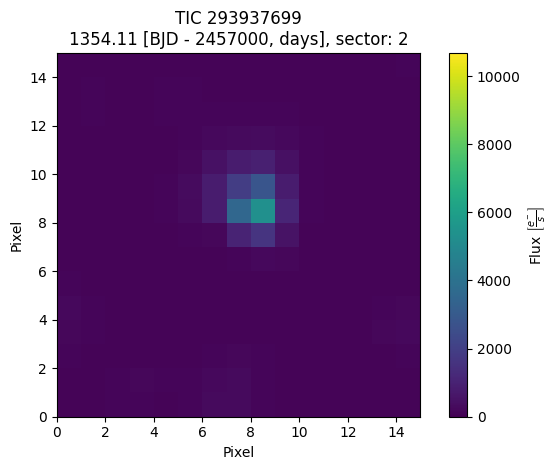

name,main_id,ids,ra,dec,period,tref,sectors,sectors_exclude,cutout_size,npixels_ap,position_ap,radius_inner_ap,radius_ap,radius_inner_skyring,radius_skyring,window_size_sop,th_sop,sigma_bottom_sc,sigma_top_sc,nintervals_sc,npoints_per_interval_sc,pmin_pc,pmax_pc
str,str,str,f64,f64,f64,f64,str,str,str,i64,str,i64,i64,f64,f64,i64,f64,f64,f64,i64,null,i64,i64
"""TIC 293937699""","""TIC 293937699""","""Gaia DR3 54902…",106.603804,-55.661744,65.108,0.0,"""2|3|6|7|8|9|10…","""8""","""15|15""",1,"""1|1""",0,2,3.0,7.5,4,0.2,2.0,0.2,10,null,6,78


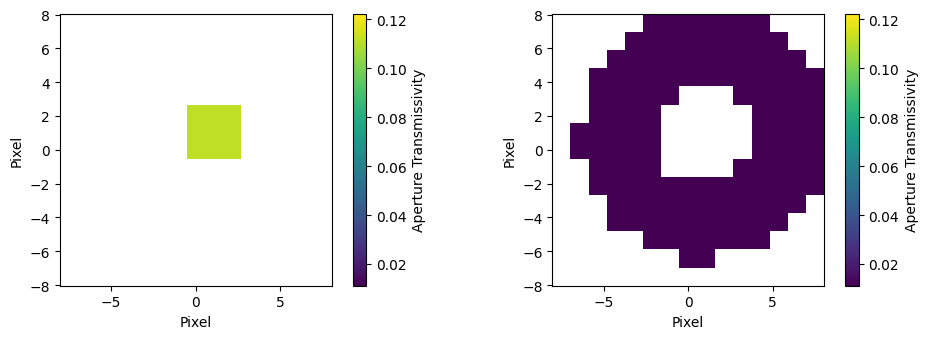

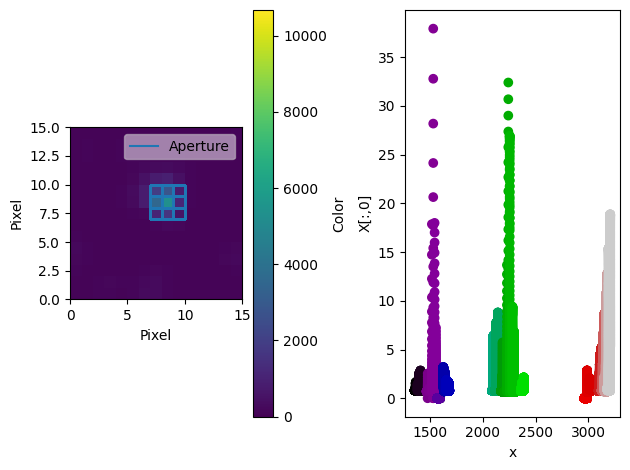

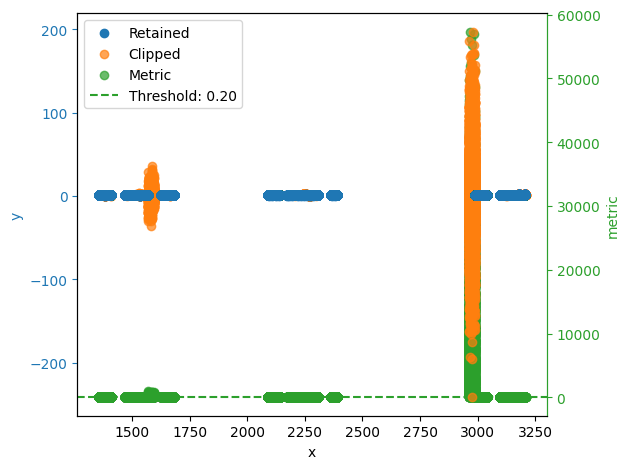

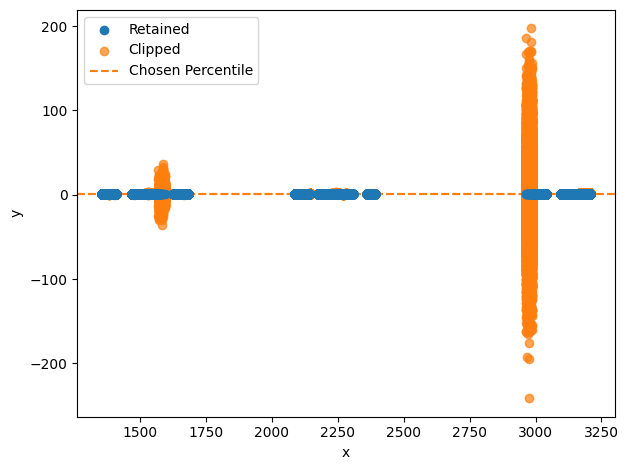

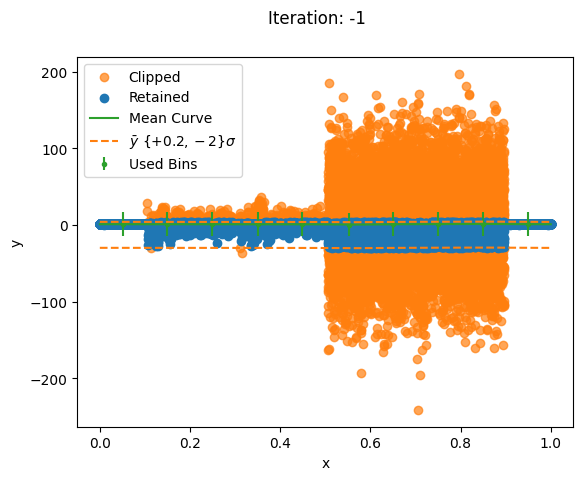

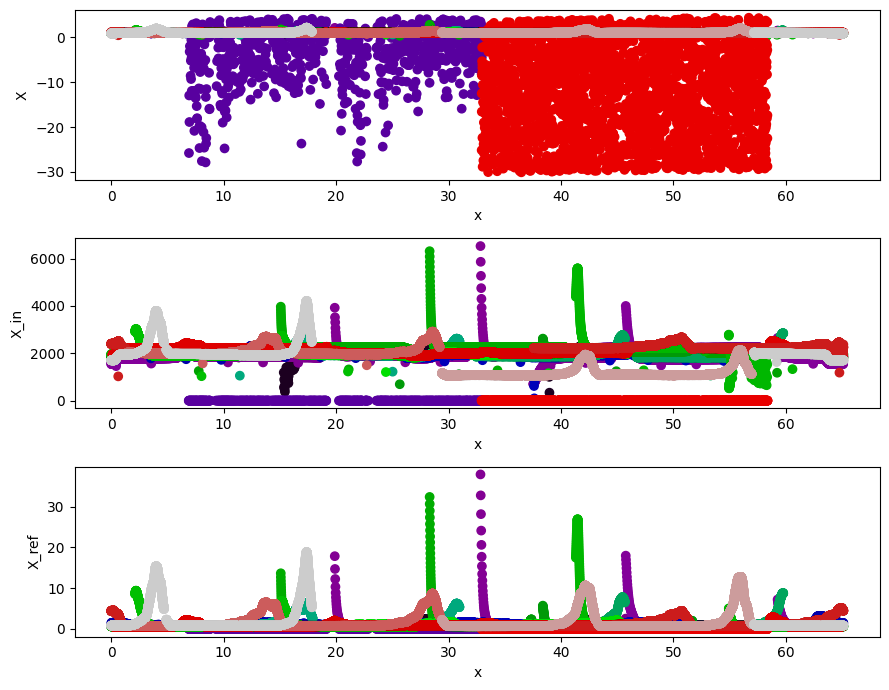

flux_corr_globnorm,flux_corr_globnorm_e,flux_corr_sectnorm,flux_corr_sectnorm_e,flux_raw,flux_raw_e,flux_sr,flux_sr_e,mask_pc,mask_sc,mask_sop,period,phase,sector,time
f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,f64,f64,i64,f64
1.03598,0.000209,0.983197,0.000198,2067.565965,0.416608,0.82423,0.004863,true,true,true,51.954396,0.797973,2,1354.114396
1.041472,0.000209,0.98841,0.000199,2078.521871,0.417688,0.823182,0.004798,true,true,true,51.975229,0.798293,2,1354.135229
1.04133,0.000209,0.988275,0.000199,2078.239699,0.41763,0.824546,0.004795,true,true,true,51.996063,0.798612,2,1354.156063
1.041897,0.000209,0.988813,0.000199,2079.369541,0.417836,0.823109,0.004798,true,true,true,52.016896,0.798932,2,1354.176896
1.041404,0.000209,0.988345,0.000199,2078.383525,0.417679,0.821429,0.004794,true,true,true,52.03773,0.799252,2,1354.19773
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.253327,0.00069,1.273056,0.000701,2505.872077,1.377276,5.531325,0.02015,false,true,false,17.835616,0.273939,69,3208.127616
1.249692,0.000689,1.269364,0.0007,2498.56703,1.375021,5.477435,0.020015,false,true,false,17.837931,0.273974,69,3208.129931
1.24393,0.000688,1.263511,0.000699,2487.016805,1.371906,5.422894,0.019953,false,true,false,17.840246,0.27401,69,3208.132246


In [8]:
#TODO: parallelize

for row in df_obj.iter_rows(named=True):
    df_obj_row = pl.from_dict(row)  #DataFrame of one row
    
    df_obj_row = get_ids_simbad(df_obj_row, verbose=verbose)
    df_obj_row, tpfs, tpfs_e, times, sectors = get_tess_cutouts(df_obj_row, verbose=verbose) 

    exec_photometry(df_obj_row, tpfs, tpfs_e, times, sectors, verbose=verbose)


## Test Reading

0.8773836779911615
1.0216233148051228


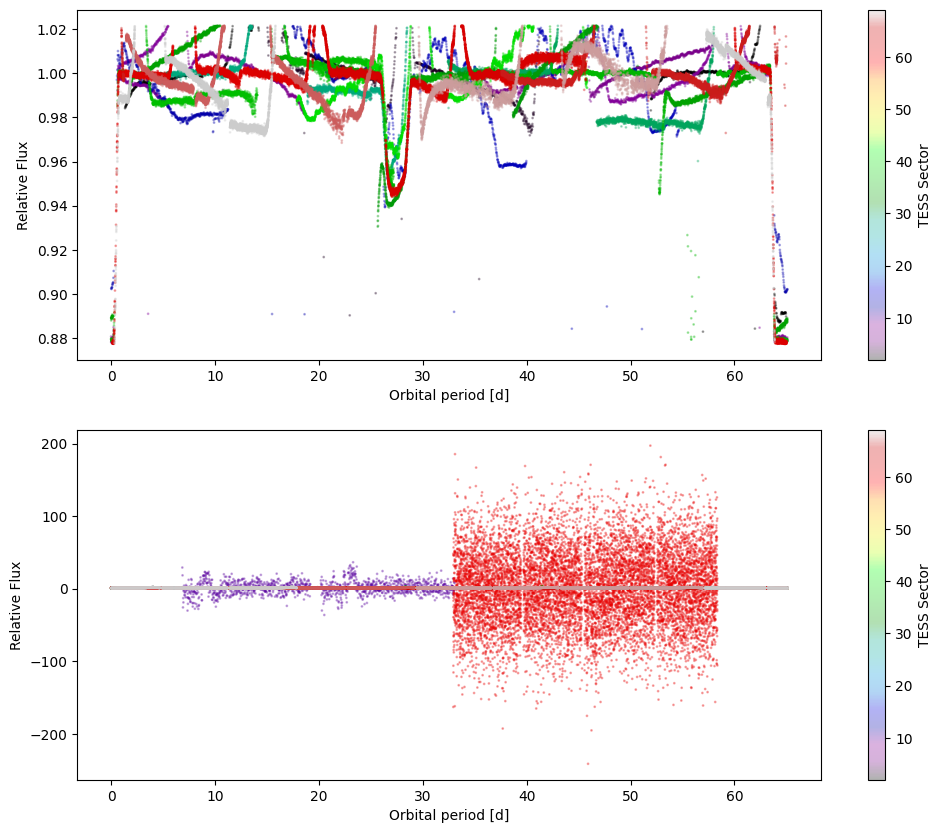

In [9]:
df_lc = pl.read_csv("TIC293937699.csv").filter(
    pl.col("mask_sc")
    &pl.col("mask_pc")
    &pl.col("mask_sop")
)
print(df_lc["flux_corr_sectnorm"].min())
print(df_lc["flux_corr_sectnorm"].max())
df_lc_nofilter = pl.read_csv("TIC293937699.csv")
df_meta = pl.read_csv("TIC293937699_meta.csv").with_columns(pl.col("sectors_exclude").cast(pl.Utf8))
sectors_exclude = df_meta["sectors_exclude"].str.split("|").item().to_numpy().astype(int)

df_lc = df_lc.filter((~pl.col("sector").is_in(sectors_exclude)))#&(pl.col("sector")<40))


fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sctr1 = ax1.scatter(df_lc["period"], df_lc["flux_corr_sectnorm"], c=df_lc["sector"], s=1, alpha=.3, cmap="nipy_spectral")
sctr2 = ax2.scatter(df_lc_nofilter["period"], df_lc_nofilter["flux_corr_sectnorm"], c=df_lc_nofilter["sector"], s=1, alpha=.3, cmap="nipy_spectral")
# for i, s in enumerate(df_lc["sector"].unique()):
#     sctr = ax1.scatter(df_lc.filter(pl.col("sector")==s)["period"], df_lc.filter(pl.col("sector")==s)["flux_corr_sectnorm"]+i, s=1, alpha=.3, cmap="nipy_spectral")
cbar1 = fig.colorbar(sctr1)
cbar2 = fig.colorbar(sctr2)
ax1.set_xlabel("Orbital period [d]")
ax2.set_xlabel("Orbital period [d]")
ax1.set_ylabel("Relative Flux")
ax2.set_ylabel("Relative Flux")
cbar1.set_label("TESS Sector")
cbar2.set_label("TESS Sector")
plt.show()